In [1]:
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [7]:
set.seed(19)
## Load data
pulsar_data <- read_csv("https://github.com/kseniak1/DSCI100-Group-Project/raw/main/HTRU_2%5B1%5D.csv", col_names = FALSE) %>%
                ## Rename Columns
                rename(mean_ip = X1,
                      dev_ip = X2,
                      excess_ip = X3,
                      skewness_ip = X4,
                      mean_dm = X5,
                      dev_dm = X6,
                      excess_dm = X7,
                      skewness_dm = X8,
                      class = X9) %>%
                ## Class as a factor
                mutate(class = as.factor(class)) %>%
                ## Select a smaller sample, adjusted for equal parts of each class
                group_by(class) %>%
                sample_n(size = 250)                
head(pulsar_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



mean_ip,dev_ip,excess_ip,skewness_ip,mean_dm,dev_dm,excess_dm,skewness_dm,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
115.2344,46.13541,0.439600186,0.5411910,2.420569,14.28331,8.962998,108.34897,0
125.6484,55.50557,-0.017358015,-0.6415455,2.060201,15.11737,10.893795,141.26112,0
123.6875,49.31797,-0.002264451,0.2187081,6.730769,31.65474,5.074507,26.22959,0
113.0078,43.74152,0.491563810,0.4636881,4.000836,20.10996,6.990697,58.85479,0
129.4062,53.41515,-0.072911778,-0.3498833,2.721572,20.16102,8.202760,71.51378,0
127.2891,49.84604,0.024368056,-0.3152955,3.773411,18.70448,6.539690,52.38843,0


In [10]:
set.seed(19)
## Split data into training and testing sets
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [11]:
set.seed(19)
## Completing a 5-fold cross-validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

In [22]:
## Base specification, recipe  and workflow (skeleton for all analysis combos)

knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
            set_engine('kknn') %>%
            set_mode('classification')

ks <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
### Uncomment below when adding predictors, rename according to graph number
# pulsar_recipe <- recipe(class ~ mean_ip/dm + predictor_2, data = pulsar_train) %>%
#                     step_scale(all_predictors()) +
#                     step_center(all_predictors())

# knn_results <- workflow() %>%
#       add_recipe(pulsar_recipe) %>%
#       add_model(knn_tune) %>%
#       tune_grid(resamples = pulsar_vfold, grid = ks) %>%
#       collect_metrics() %>% 
#       filter(.metric == "accuracy")
# knn_results

# knn_plot <- ggplot(knn_results, aes(x = neighbors, y = mean))+
#       geom_point() +
#       geom_line() +
#       labs(x = "Neighbors", y = "Accuracy Estimate")
# knn_plot

Six different pairings of variables will be tested:

Integrated Profile:
1. Mean and Standard Deviation
2. Mean and Excess Kurtosis
3. Mean and Skewness

DM-SNR Curve:

4. Mean and Standard Deviation
5. Mean and Excess Kurtosis
6. Mean and Skewness

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.8082504,5,0.019135925,Model01
2,accuracy,binary,0.8082504,5,0.019135925,Model02
3,accuracy,binary,0.8644381,5,0.009491358,Model03
4,accuracy,binary,0.8644381,5,0.009491358,Model04
5,accuracy,binary,0.8831437,5,0.010209790,Model05
6,accuracy,binary,0.8831437,5,0.010209790,Model06
7,accuracy,binary,0.8832148,5,0.012301326,Model07
8,accuracy,binary,0.8832148,5,0.012301326,Model08
9,accuracy,binary,0.8831437,5,0.009221161,Model09


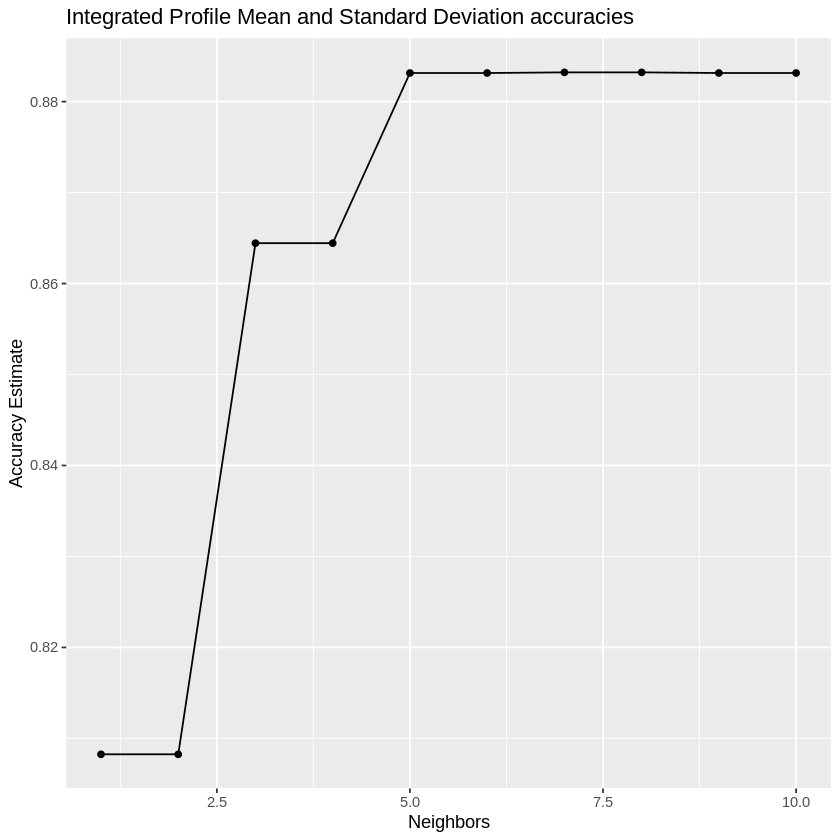

In [26]:
## Pairing 1
pulsar_recipe1 <- recipe(class ~ mean_ip + dev_ip, data = pulsar_train) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

knn_results1 <- workflow() %>%
      add_recipe(pulsar_recipe1) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = pulsar_vfold, grid = ks) %>%
      collect_metrics() %>% 
      filter(.metric == "accuracy")
knn_results1

knn_plot1 <- ggplot(knn_results1, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("Integrated Profile Mean and Standard Deviation accuracies")
knn_plot1